# Diving Deeper

> Matrix math, from scratch

Adapted from:
- https://www.youtube.com/watch?v=6StU6UtZEbU&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=3&t=1623s

In [1]:
#| default_exp diving_deeper

In [2]:
#| export
import gzip
import os
import pickle
from dataclasses import dataclass
from pathlib import Path
from typing import Any, List

import matplotlib.pyplot as plt
import requests
import torch

from slowai.overview import show_image

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Matrix notation and playing with data
### Get the data

In [3]:
#| export
# Get the data
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"


def download_file(url, destination):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(destination, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)


def download_mnist(path_gz=Path("./data") / "mnist.pkl.gz"):
    path_gz.parent.mkdir(exist_ok=True, parents=True)
    download_file(MNIST_URL, path_gz)
    return path_gz


data_fp = download_mnist()
data_fp

PosixPath('data/mnist.pkl.gz')

In [4]:
with gzip.open(data_fp, "rb") as f:
    data = pickle.load(f, encoding="latin-1")
    ((X_trn, y_trn), (X_vld, y_vld), _) = data
X_trn.shape

(50000, 784)

Note that $784 = 28^2$

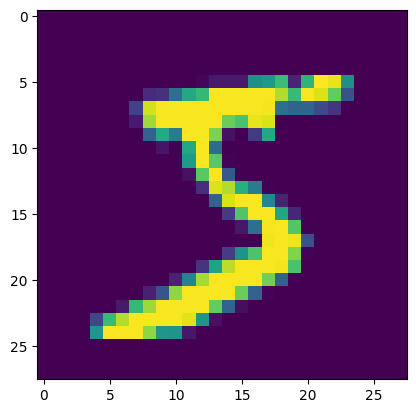

In [5]:
fig, ax = plt.subplots(1, 1)
ax.imshow(X_trn[0].reshape(28, 28))

### Writing a matrix class

In [6]:
@dataclass
class Matrix:
    xs: List[List[float]]

    def __getitem__(self, idxs):
        x, y = idxs
        return self.xs[x][y]

This is implemented by PyTorch (along with all the auto-differentiation stuff)

In [7]:
torch.Tensor?

Init signature: torch.Tensor(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/miniforge3/envs/slowai/lib/python3.9/site-packages/torch/__init__.py
Type:           _TensorMeta
Subclasses:     Parameter, UninitializedBuffer, FakeTensor, MaskedTensor

# History of Tensor Programming

This goes back to the invention of the [APL language](dataclass). It started with a mathematical notation that was later adapted as a programming language in the 1960s by Kenneth Iverson and Adin Falkoff. This was extended with their physics research into Tensor Analysis.

You can try it [here](http://tryapl.org).

## APL functionality

Defining a tensor (or "arrays," using their own terminology), `a`.

```apl
a ⃪ 3 5 6
```

Multiplying by a scalar

```apl
a ⨉ 3
```

Element-wise division

```apl
b ⃪ 7 8 9
a ÷ b
```

Numpy was influenced by APL, PyTorch was influenced by numpy.

One thing that differs is that scalars are just "1-rank" tensors in numpy, whereas they have special scalars have special semantics in numpy.

# Random numbers

There is no way to generate random numbers from a typical computer. You have to look at natural phenomenon for true randomness.

- [Measuring the quantum fluctuations of the vacuum](https://qrng.anu.edu.au)
- [Sample from the the pixels in a live feed of lava lamps](https://blog.cloudflare.com/randomness-101-lavarand-in-production/)
- [On-chip entropy source](https://en.wikipedia.org/wiki/RDRAND)

Generally, all we need is pseudo-randomness, like the [Wichmann Hill algorithm](https://en.wikipedia.org/wiki/Wichmann–Hill).

In [21]:
@dataclass
class RNG:
    x = None
    y = None
    z = None

    def seed(self, a):
        a, x = divmod(a, 30268)
        a, y = divmod(a, 30306)
        a, z = divmod(a, 30322)
        self.x = int(x) + 1
        self.y = int(y) + 1
        self.z = int(z) + 1

    def random(self):
        self.x = (171 * self.x) % 30269
        self.y = (172 * self.y) % 30307
        self.z = (170 * self.z) % 30323
        return (self.x / 30268 + self.y / 30306 + self.z / 30322) % 1


rng = RNG()
rng.seed(42)
rng.random(), rng.random(), rng.random()

(0.25421176102342913, 0.4689255225976794, 0.19544471247365425)

It is important to keep in mind the Unix process semantics for random numbers. What happens if we fork the process?

In [23]:
if os.fork():
    print(f"parent process: {rng.random():.2f}")
else:
    print(f"child process: {rng.random():.2f}")

parent process: 0.86
child process: 0.86


These are the same number! This is because the internals of the RNG are forked. You need to reseed the RNG for each process, like so.

In [25]:
if os.fork():
    rng.seed(42)
    print(f"parent process: {rng.random():.2f}")
else:
    rng.seed(43)
    print(f"child process: {rng.random():.2f}")

parent process: 0.25
child process: 0.26


In [8]:
#| hide
import nbdev

nbdev.nbdev_export()